## 激光雷达圆孔扫描
- 汪星宇
- 2022年2月

### 1. 问题描述


### 2. 基本思路
1. 拟合平面，删除噪点
2. 分割线段，确定质心
3. 确定边界点，确定圆心和半径


### 3. 问题求解
#### 3.1 拟合平面，删除噪点
采用`RANSAC`方法拟合平面，open3d的内置算法`<pointcloud>.segment_plane`

>或者采用最小二乘方法拟合平面：
> https://blog.csdn.net/qq_36686437/article/details/117881459?ops_request_misc=%257B%2522request%255Fid%2522%253A%2522164482097816780261993076%2522%252C%2522scm%2522%253A%252220140713.130102334.pc%255Fall.%2522%257D&request_id=164482097816780261993076&biz_id=0&utm_medium=distribute.pc_search_result.none-task-blog-2~all~first_rank_ecpm_v1~rank_v31_ecpm-3-117881459.pc_search_insert_es_download&utm_term=open3d%E7%9B%B4%E7%BA%BF%E6%8B%9F%E5%90%88&spm=1018.2226.3001.4187

In [169]:
import numpy as np
import open3d as o3d

points = np.loadtxt("../data/孔测试数据/20220214-2.txt", delimiter=',')
# points = np.loadtxt("../data/孔测试数据/1.txt", delimiter=',')
# 点云读取
source = o3d.geometry.PointCloud()
source.points = o3d.utility.Vector3dVector(points)

print("\n读取点云数据：", source)


读取点云数据： PointCloud with 16936 points.


In [170]:
# 计算平面方程
plane, inliers = source.segment_plane(distance_threshold=0.08, ransac_n=20, num_iterations=1000)

print(f"\n平面方程：{plane[0]:.2f}x + {plane[1]:.2f}y + {plane[2]:.2f}z + {plane[3]:.2f} =0")


平面方程：1.00x + -0.04y + 0.00z + -2197.22 =0


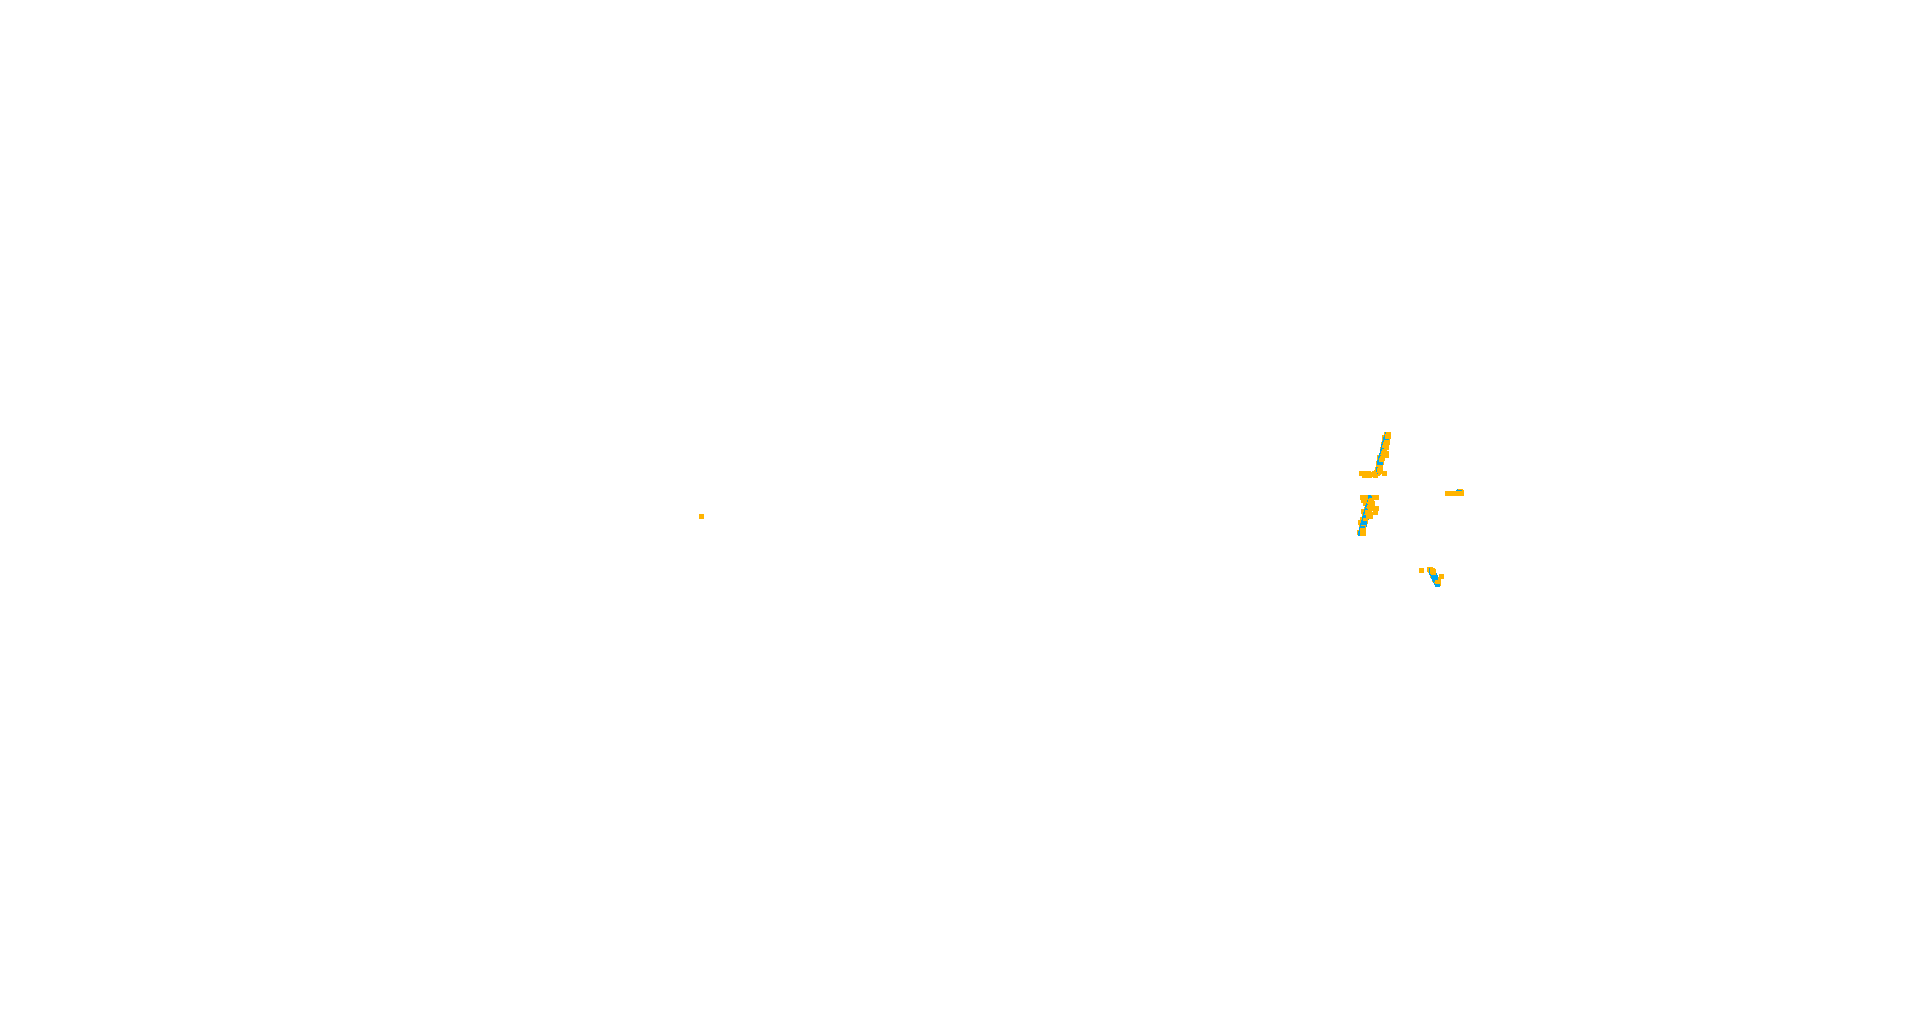

In [171]:
# 实现 notebook 行间显示功能
import open3d_tutorial

# 显示
inliers_points = source.select_by_index(inliers)
inliers_points.paint_uniform_color([0, 0.651, 0.929])
outliers_points = source.select_by_index(inliers, invert=True)
outliers_points.paint_uniform_color([1, 0.706, 0])
o3d.visualization.draw_geometries([inliers_points, outliers_points],window_name="原始点云")

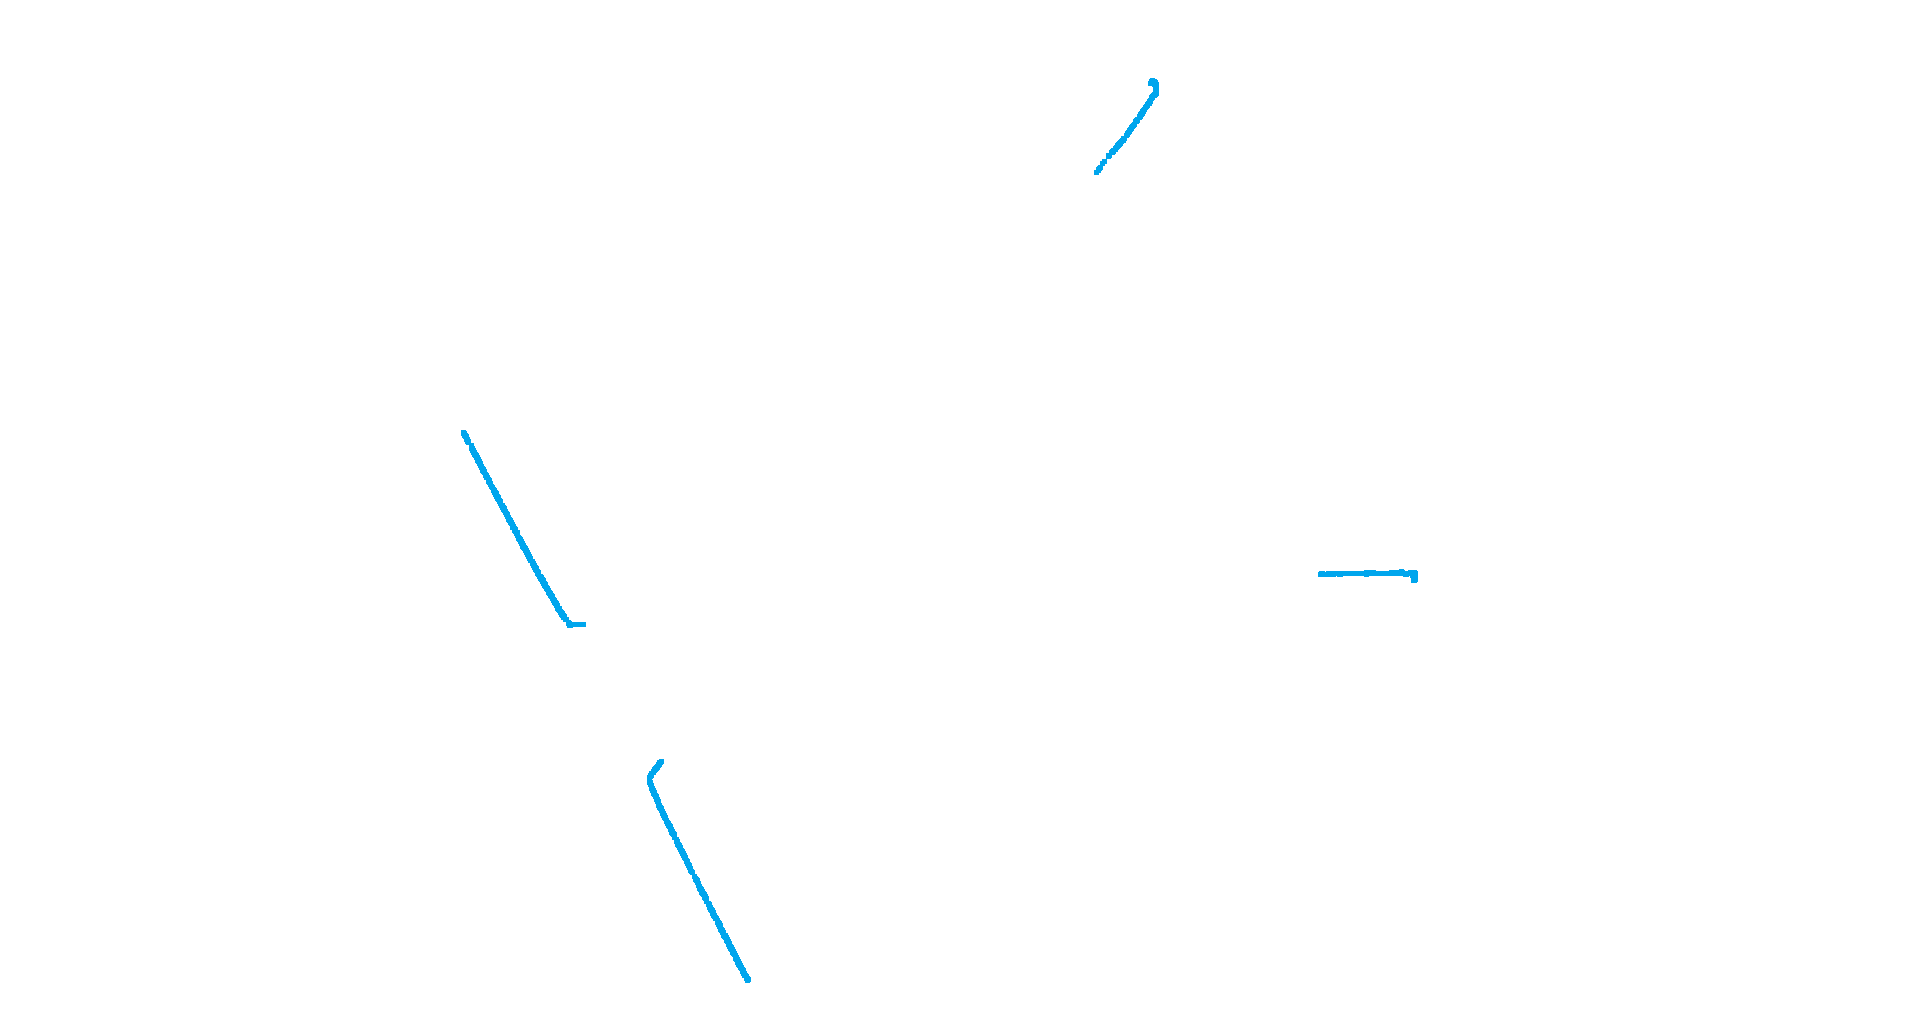

In [172]:
o3d.visualization.draw_geometries([inliers_points],window_name="平面去噪后点云")

#### 3.2 分割线段，确定质心


[Open3D DEBUG] Precompute neighbors.
Clustering[========================================] 100%
Precompute neighbors.[=======================================>] 97%=>                                  ] 12%
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 4Precompute neighbors.[========================================] 100%
Clustering[=>                                      ] 2%

点云有 4 簇



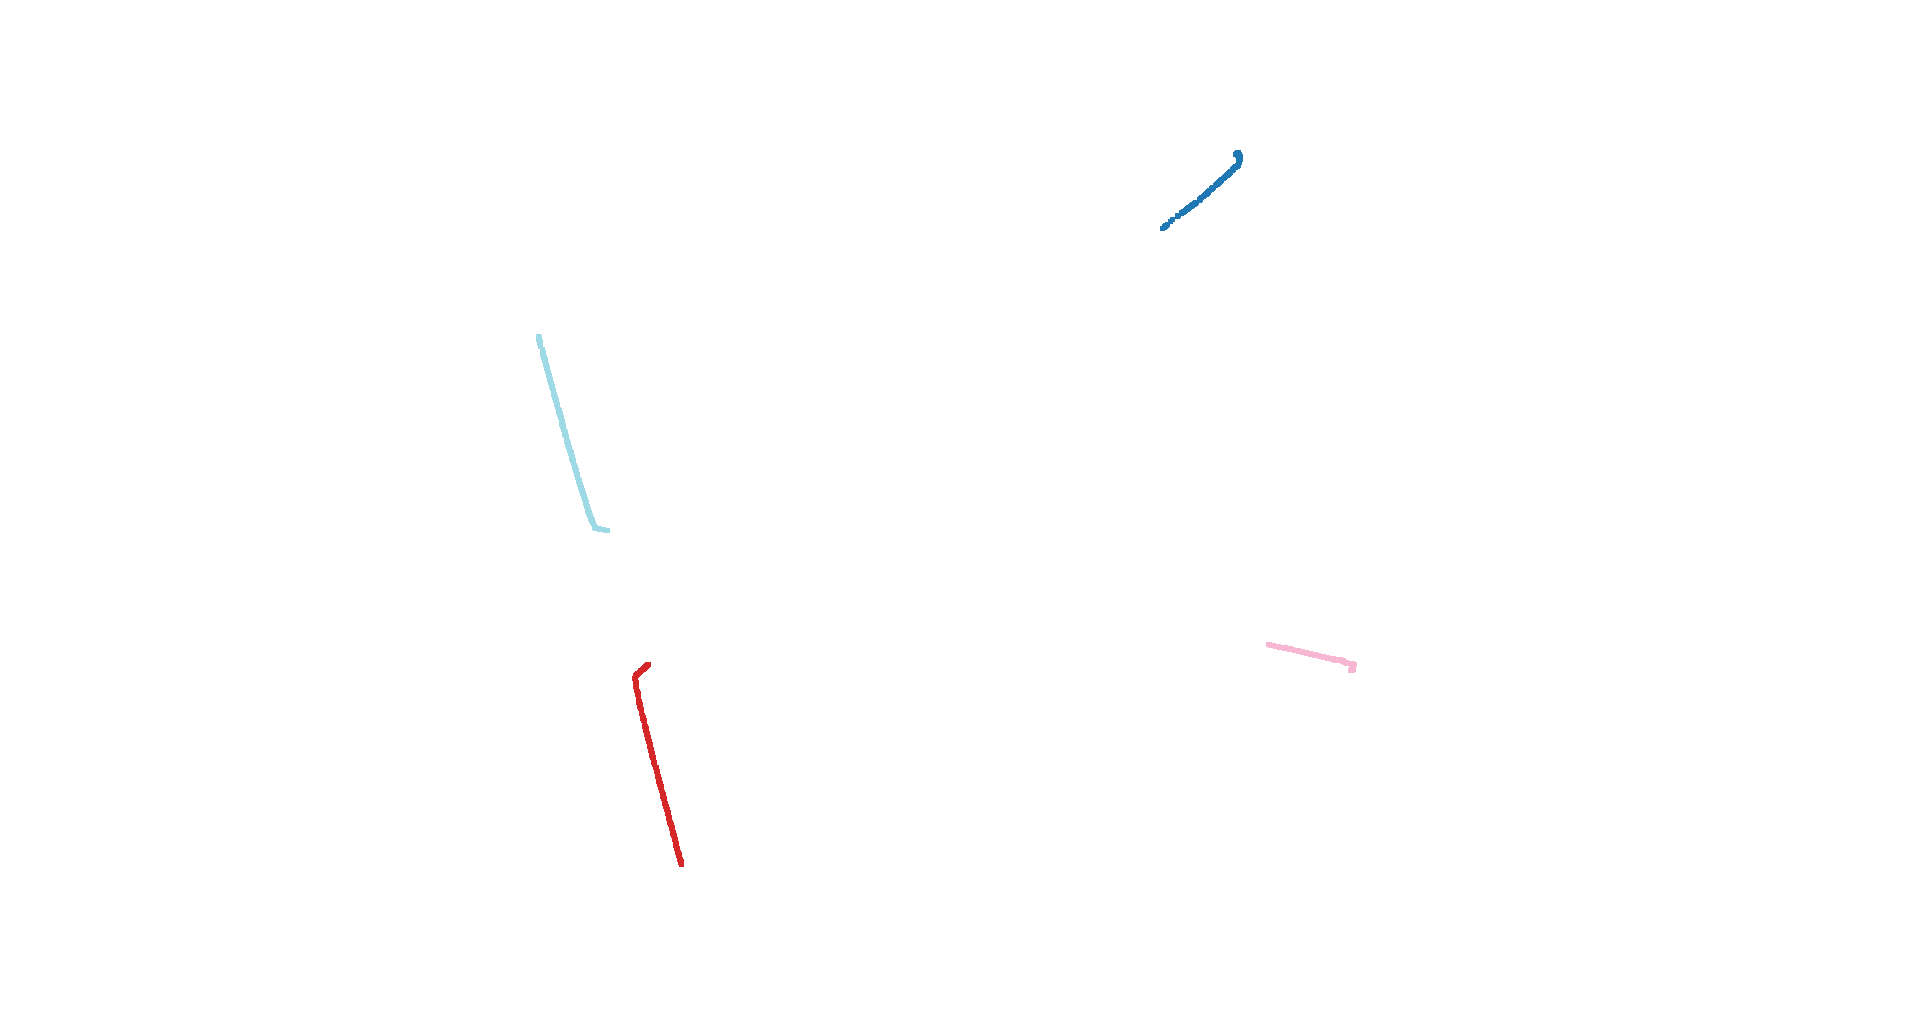

In [173]:
# 密度聚类
eps = 0.5  # 同一聚类中最大点间距
min_points = 50  # 有效聚类的最小点数
with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array(inliers_points.cluster_dbscan(eps, min_points, print_progress=True))
max_label = labels.max()
print(f"\n点云有 {max_label + 1} 簇\n")  # label = -1 为噪声, 有效数据从 label=0 开始

# 显示聚类分割结果
import matplotlib.pyplot as plt
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0  # labels = -1 的簇为噪声，以黑色显示
inliers_points.colors = o3d.utility.Vector3dVector(colors[:, :3])
o3d.visualization.draw_geometries([inliers_points])


In [174]:
# 计算一团点云的质心
center = inliers_points.get_center().reshape((-1,3))
print("点云质心为：", center)


点云质心为： [[2188.20988729 -292.09332912 -556.50287162]]


#### 3.3 确定边界点，确定圆心和半径

In [175]:
def ClosestPoint(A, points):
    """
    返回points中最接近A点的点云点
    :param A:
    :param points:
    :return:
    """
    temp = o3d.geometry.PointCloud()
    temp.points = o3d.utility.Vector3dVector(A)
    # 计算到A点距离
    dists = np.asarray(points.compute_point_cloud_distance(temp))
    return np.argmin(dists)

edge_points = []
# 按分割结果计算离质心最近点云
for i in range(max_label+1):
    index = np.argwhere(labels == i)
    # 第i块聚类
    cluster_i = inliers_points.select_by_index(index)
    edge_points.append(cluster_i.points[ClosestPoint(center, cluster_i)])

edge_points = np.asarray(edge_points)
print("圆孔边缘点坐标",edge_points)

圆孔边缘点坐标 [[2188.451664 -285.69591  -544.760544]
 [2188.103167 -293.84986  -562.230538]
 [2187.869931 -298.208673 -544.793633]
 [2188.263317 -289.879161 -562.268553]]


In [176]:
# 利用最小二乘求解圆(球)方程
# 参考 https://zhuanlan.zhihu.com/p/97036816

x = edge_points[:, 0]
y = edge_points[:, 1]
z = edge_points[:, 2]
# print(x.size)

A = np.asarray([-2*x, -2*y, -2*z, 0*x+1])
B = -1*x**2 - y**2 - z**2

X=np.linalg.lstsq(A, B, rcond = -1)
print("\n方程的解为：",X[0])

a = X[0][0]
b = X[0][1]
c = X[0][2]
r = (a**2+b**2+c**2-X[0][3])**0.5

print(f"\n圆(球)方程为：(x-{a:.2f})^2 + (y-{b:.2f})^2 + (z-{c:.2f})^2 = {r:.2f}^2")


方程的解为： [ 1.47079504e+11  4.66930986e+11 -1.48540566e+11 -4.65475113e+11]

圆(球)方程为：(x-147079503887.52)^2 + (y-466930985695.71)^2 + (z--148540565573.79)^2 = 511586967668.27^2


In [177]:
X


(array([ 1.47079504e+11,  4.66930986e+11, -1.48540566e+11, -4.65475113e+11]),
 array([], dtype=float64),
 4,
 array([9.10357225e+03, 3.38955268e+01, 1.85104041e+01, 7.50342881e-06]))